In [1]:
import re
import pandas as pd
import numpy as np
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, LabelEncoder

from catboost import CatBoostRegressor

from data_processing import extract_vin_price_pairs, is_valid_vin, transform_data


In [2]:
# Чтение данных из файла
with open('vin_ford_train.txt', 'r') as file:
    data = file.read()

In [3]:
# Найдем все пары ВИН-код - цена.

df = extract_vin_price_pairs(data)

# Выводим датафрейм
display(df.head())

,VIN_code,price
0,2FMDK3JC4BBA41556,12500
1,3FA6P0H75ER208976,14500
2,3FAHP08Z17R268380,1300
3,1FMCU0GX3DUC59421,15200
4,1FAHP2E89DG119368,11600


In [4]:
# Проверим валидность VIN-кодов. 
# При проверке используем логику для проверки контрольной суммы VIN-кода по алгоритму Luhn.

# Применяем функцию к столбцу 'VIN_code' и создаем маску для невалидных VIN-кодов
invalid_vin_mask = ~df['VIN_code'].apply(is_valid_vin)

# Создаем датафрейм с невалидными VIN-кодами
invalid_vin_df = df[invalid_vin_mask]

# Удаляем невалидные VIN-коды из исходного датафрейма
df = df[~invalid_vin_mask]

# Выводим датафрейм с невалидными VIN-кодами
print("Невалидные VIN-коды:")
print(invalid_vin_df)

Невалидные VIN-коды:
               VIN_code  price
1309  1FM5K8D83DGB9100X  26600


Проведем исследовательский анализ данных.  
При исследовании сделаем несколько допущений и гипотез:  
1. Предположим, что страна производства и автозавод прямо влияют на стоимость автомобиля. Поэтому при кодировании этих категориальных данных будем либо использовать частотный способ кодирования, либо использовать данные рейтингов надежности.
2. Также влияет на стоимость объем двигателя и вид топлива. Однако во-первых эта зависимость нелинейная, во-вторых, требуется отдельное исследование этих зависимостей.
3. Разделим датафрейм на тренировочную и тестовую выборки, а также выделим 5 кодов для тестирования функции предсказания.

In [5]:
# создадим копию датафрейма для исследования. 
# В случае выявления интересных признаков будем добавлять их в основной датафрейм.

df_EDA = df.copy()

In [6]:
df_EDA['price'].describe()

count    71884.000000
mean     14321.449377
std       7827.057238
min       1000.000000
25%       8800.000000
50%      13500.000000
75%      19500.000000
max      36500.000000
Name: price, dtype: float64

In [7]:
# Выделение компонентов VIN-кода
df_EDA['WMI_country'] = df_EDA['VIN_code'].str[0]  # Страна производства
df_EDA['WMI_manufacturer'] = df_EDA['VIN_code'].str[1:3]  # Код производителя
df_EDA['VDS_model'] = df_EDA['VIN_code'].str[3:6]  # Модель автомобиля
df_EDA['VDS_body_type'] = df_EDA['VIN_code'].str[6]  # Тип кузова автомобиля
df_EDA['VDS_engine_type'] = df_EDA['VIN_code'].str[7]  # Тип двигателя
df_EDA['VDS_check_digit'] = df_EDA['VIN_code'].str[8]  # Контрольная цифра, используемая для проверки валидности VIN кода
df_EDA['year_of_manufacture'] = df_EDA['VIN_code'].str[9]  # Год производства
df_EDA['assembly_plant_code'] = df_EDA['VIN_code'].str[10]  # Код завода-изготовителя, на котором была собрана или завершена сборка автомобиля
df_EDA['specific_vehicle_characteristics'] = df_EDA['VIN_code'].str[11]  # Специфические характеристики транспортного средства
df_EDA['VIS_serial_number'] = df_EDA['VIN_code'].str[12:]  # Заводской номер автомобиля
df_EDA.drop(['VIN_code'], axis=1, inplace=True)

display(df_EDA.head())


,price,WMI_country,WMI_manufacturer,VDS_model,VDS_body_type,VDS_engine_type,VDS_check_digit,year_of_manufacture,assembly_plant_code,specific_vehicle_characteristics,VIS_serial_number
0,12500,2,FM,DK3,J,C,4,B,B,A,41556
1,14500,3,FA,6P0,H,7,5,E,R,2,08976
2,1300,3,FA,HP0,8,Z,1,7,R,2,68380
3,15200,1,FM,CU0,G,X,3,D,U,C,59421
4,11600,1,FA,HP2,E,8,9,D,G,1,19368


In [8]:
# Получим уникальные значения столбца WMI_country
unique_countries = df_EDA['WMI_country'].unique()
print(unique_countries)

['2' '3' '1' '4']


Эти коды соответствуют ISO 3166-1 alpha-2 кодам стран
'2': Канада (CA)
'3': Мексика (MX)
'1': США (US)
'4': США (US)
Заменим данные на страны

In [9]:
# Создаем словарь для замены кодов стран на названия на английском языке
country_mapping = {'2': 'Canada', '3': 'Mexico', '1': 'United States', '4': 'United States'}

# Производим замену в столбце 'WMI_country'
df_EDA['WMI_country'] = df_EDA['WMI_country'].replace(country_mapping)

C:\Users\14488\AppData\Local\Temp\ipykernel_11460\2395829065.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='WMI_country', data=df_EDA, palette='bright')


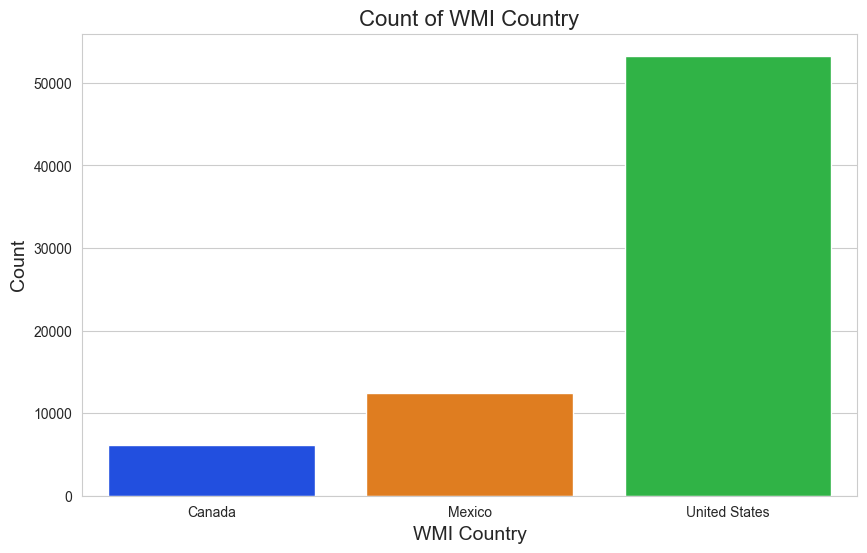

In [10]:
# Нарисуем графики

# Устанавливаем стиль графика
sns.set_style("whitegrid")

# Строим countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='WMI_country', data=df_EDA, palette='bright')

# Добавляем заголовок
plt.title('Count of WMI Country', fontsize=16)

# Добавляем подписи к осям
plt.xlabel('WMI Country', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Показываем график
plt.show()

Больше всего автомобилей производства США. При кодировании будем производить замену по частотному принципу.

In [11]:
# Посмотрим, что у нас с производителями

# Получим уникальные значения столбца WMI_country
unique_countries = df_EDA['WMI_manufacturer'].unique()
print(unique_countries)

['FM' 'FA' 'FT' 'ZV' 'FD' 'FB' 'F2' 'F4' 'N2']


Это все один производитель: Ford Motor Company. Оставим числовые характеристики

C:\Users\14488\AppData\Local\Temp\ipykernel_11460\1962755887.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_EDA, x='WMI_manufacturer', palette='bright')


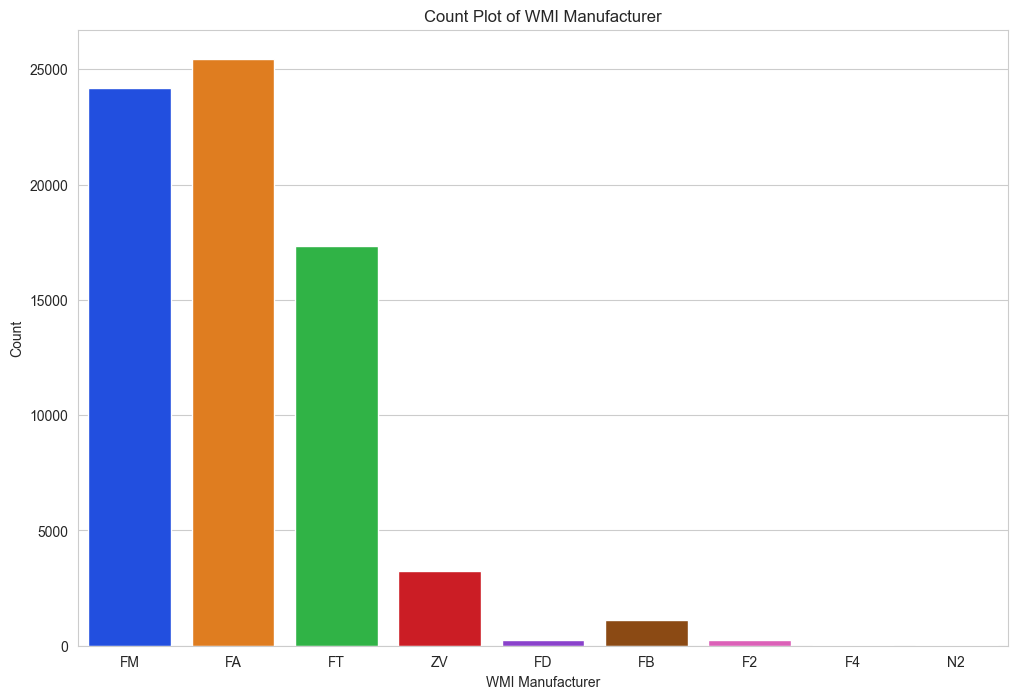

In [12]:
# Рисуем график по производителям

plt.figure(figsize=(12, 8))
sns.countplot(data=df_EDA, x='WMI_manufacturer', palette='bright')
plt.title('Count Plot of WMI Manufacturer')
plt.xlabel('WMI Manufacturer')
plt.ylabel('Count')
plt.show()

Замену также будем производить по частотному методу

In [13]:
# Смотрим, что у нас с моделями

unique_countries = df_EDA['VDS_model'].unique()
print(unique_countries)

['DK3' '6P0' 'HP0' 'CU0' 'HP2' '5K8' 'FW1' 'ZU6' 'CU9' 'GK5' 'DK4' 'FX1'
 'BP8' 'NE1' 'JK1' 'PX1' 'FT8' 'MF1' 'NE2' 'NF1' 'DP3' 'HP3' 'RW1' 'EU3'
 'NF2' 'FU1' 'PU1' 'SW2' 'KR1' 'DP4' 'RF1' 'ZU7' 'FP5' 'RU1' 'PW1' 'HK8'
 'RX1' 'YR1' 'EW1' 'FP3' 'HP7' 'SS3' 'EU6' 'CZ9' 'DA5' 'DK0' '5K7' 'FK1'
 'RW0' 'XW4' 'HK7' 'HK6' 'ZF1' 'NX2' '8W3' 'HT8' 'FP4' 'SE3' 'YU9' 'DX1'
 'CZ0' 'FP2' 'YZ0' 'DU7' 'FP1' 'NE3' 'WW3' 'EU7' 'DP5' 'SW3' 'RX0' 'ZX1'
 '7X2' 'YU0' 'DP0' 'VX1' 'FP0' 'CU5' 'YR4' 'DK5' 'CU2' '7W2' 'NW2' 'EU1'
 'LR4' 'KR4' 'EX1' 'ZR4' 'PW0' 'ZK0' 'CU4' 'SX2' 'JU2' 'YZ9' 'EK6' 'YU6'
 '7X3' 'JU1' 'NU4' 'SF2' '6P8' 'DF1' 'ZF0' 'LP4' 'VW1' 'DU6' 'FU2' 'BP7'
 'YU7' 'LR1' 'RF0' 'NS2' 'BF2' 'CR1' 'ZA5' 'HP6' 'FK2' 'JK2' '7W3' 'ZR1'
 'EU5' 'FP7' 'SU4' 'PF1' 'PX0' 'ZU8' '8W4' 'RE1' 'DX0' 'NR2' 'XF4' 'DU3'
 'WX3' 'EX0' '8X3' 'ZU3' 'EF1' 'HP5' 'WF3' 'EU8' 'SX3' 'VF1' 'XE4' 'WE3'
 'SF3' 'YR2' 'DU8' 'ZN1' 'PE2' 'CZ4' 'YU4' 'ZX2' 'YE1' 'YU2' 'EE3' 'LP7'
 'LP6' 'HX2' 'CU6' 'LP5' 'LP1' 'PU2' '4E4' 'ZX0' 'K

In [14]:
# Смотрим, что у нас с типом кузова

unique_countries = df_EDA['VDS_body_type'].unique()
print(unique_countries)

['J' 'H' '8' 'G' 'E' 'D' 'C' '4' 'K' 'B' '6' '2' 'F' 'R' '1' '0' '5' '7'
 'L' 'A' '3' 'M' '9' 'N' 'T' 'P' 'S' 'Z' 'Y' 'X' 'U']


In [15]:
# Смотрим, что у нас с типом двигателя

unique_countries = df_EDA['VDS_engine_type'].unique()
print(unique_countries)

['C' '7' 'Z' 'X' '8' 'F' 'T' 'W' 'G' 'M' '5' '1' '9' 'H' 'A' '2' 'N' 'U'
 'E' 'R' 'L' 'P' 'D' 'J' 'K' '3' '4' 'V' '6' 'S' 'Y' 'B']


In [16]:
# Смотрим, что у нас с годом производства

unique_countries = df_EDA['year_of_manufacture'].unique()
print(unique_countries)

['B' 'E' '7' 'D' 'C' '3' 'A' '5' '4' '9' '8' 'X' '6' 'Y' 'F' '2' 'W' 'V'
 '1' 'S' 'T' 'R' 'H' 'K' 'P']


In [17]:
# Заменим известные года производства

year_mapping = {
    'B': 2011, 'E': 2014, '7': 2007, 'D': 2013, 'C': 2012,
    '3': 2003, 'A': 2010, '5': 2005, '4': 2004, '9': 2009,
    '8': 2008, 'X': 1999, '6': 2006, 'Y': 2000, 'F': 2015,
    '2': 2002, 'W': 2001, 'V': 2002, '1': 2001, 'S': 1995,
    'T': 1996, 'R': 1994, 'H': 1987, 'K': 1989, 'P': 1993
}

# Заменяем значения в столбце year_of_manufacture с использованием словаря
df_EDA['year_of_manufacture'] = df_EDA['year_of_manufacture'].map(year_mapping)

In [18]:
# Смотрим, что у нас с заводами окончательной сборки

unique_countries = df_EDA['assembly_plant_code'].unique()
print(unique_countries)

['B' 'R' 'U' 'G' 'F' 'K' '5' 'D' 'E' 'N' 'L' 'W' 'P' 'M' 'A' 'X' 'C' 'Z'
 'H' 'Y' 'T']


In [19]:
# Смотрим, что у нас со специальными характеристиками

unique_countries = df_EDA['specific_vehicle_characteristics'].unique()
print(unique_countries)

['A' '2' 'C' '1' 'D' 'B' 'E' 'F' '3' '4' 'M' '5' 'G' '8']


In [20]:
# Смотрим общую информацию
df_EDA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71884 entries, 0 to 71884
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   price                             71884 non-null  int64 
 1   WMI_country                       71884 non-null  object
 2   WMI_manufacturer                  71884 non-null  object
 3   VDS_model                         71884 non-null  object
 4   VDS_body_type                     71884 non-null  object
 5   VDS_engine_type                   71884 non-null  object
 6   VDS_check_digit                   71884 non-null  object
 7   year_of_manufacture               71884 non-null  int64 
 8   assembly_plant_code               71884 non-null  object
 9   specific_vehicle_characteristics  71884 non-null  object
 10  VIS_serial_number                 71884 non-null  object
dtypes: int64(2), object(9)
memory usage: 6.6+ MB


Выводы по этапу:
1. Загрузили и посмотрели данные.
2. Выяснили, как подготавливать данные для обучения моделей и последующих предсказаний.
3. В выборке представлены ВИН-коды одного производителя 3 разных стран производства.
4. Сборка автомобилей производилась на разных заводах, также на нескольких заводах производилась окончательная сборка автомобилей.
5. Каждый из этих признаков является значимым в рамках поставленной задачи, однако требует отдельного исследования по каждому пункту. В связи с отсутствием времени, а также принимая во внимание, что задача состоит в изучении регулярных выражений, данные исследования проводить не будем.
6. Одним из важнейших признаков является год выпуска, однако определить год выпуска для некоторых автомобилей не представляется возможным

In [21]:
# Разделяем данные на обучающий и тестовый наборы
X = df.drop(['price'], axis=1)  # Входные признаки
y = df['price']  # Целевая переменная

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# Проверка размеров наборов данных
print("Размер обучающего набора данных:", X_train.shape[0])
print("Размер тестового набора данных:", X_test.shape[0])

Размер обучающего набора данных: 57507
Размер тестового набора данных: 14377


Создаем функцию про преобразованию данных с учетом проведенного анализа:
1. Разделяем VIN код на составляющие
2. Удаляем столбец VDS_check_digit как не несущий никакой информации
3. Преобразование категориальных признаков [WMI_country, WMI_manufacturer, VDS_model, VDS_body_type, VDS_engine_type] на основе частотности 
4. Масштабируем признаки.

In [22]:
# Преобразуем тренировочную и тестовую выборки

# Применяем функцию transform_data к X_train
X_train_transformed = transform_data(X_train)

# Применяем ту же функцию к X_test
X_test_transformed = transform_data(X_test)


In [23]:
# Создаем модель CatBoostRegressor
model = CatBoostRegressor(silent=True)

# Обучаем модель на обучающих данных
model.fit(X_train_transformed, y_train)

# Сохраним модель
model.save_model('catboost_model.cbm') 

# Делаем предсказания на тестовых данных
y_pred = model.predict(X_test_transformed)

In [24]:
# Вычисляем MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Вычисляем RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Вычисляем MSE
mse = mean_squared_error(y_test, y_pred)

# Вычисляем MAE
mae = mean_absolute_error(y_test, y_pred)

# Вычисляем R2
r2 = r2_score(y_test, y_pred)

# Собираем все метрики в таблицу
metrics = pd.DataFrame({'Metric': ['MAPE', 'RMSE', 'MSE', 'MAE', 'R2'],
                        'Value': [mean_absolute_percentage_error(y_test, y_pred), rmse, mse, mae, r2]})

# Округляем значения метрик до двух знаков после запятой
metrics['Value'] = metrics['Value'].round(2)

# Выводим таблицу с метриками
display(metrics)


,Metric,Value
0,MAPE,19.81
1,RMSE,2790.63
2,MSE,7787619.35
3,MAE,1940.67
4,R2,0.87


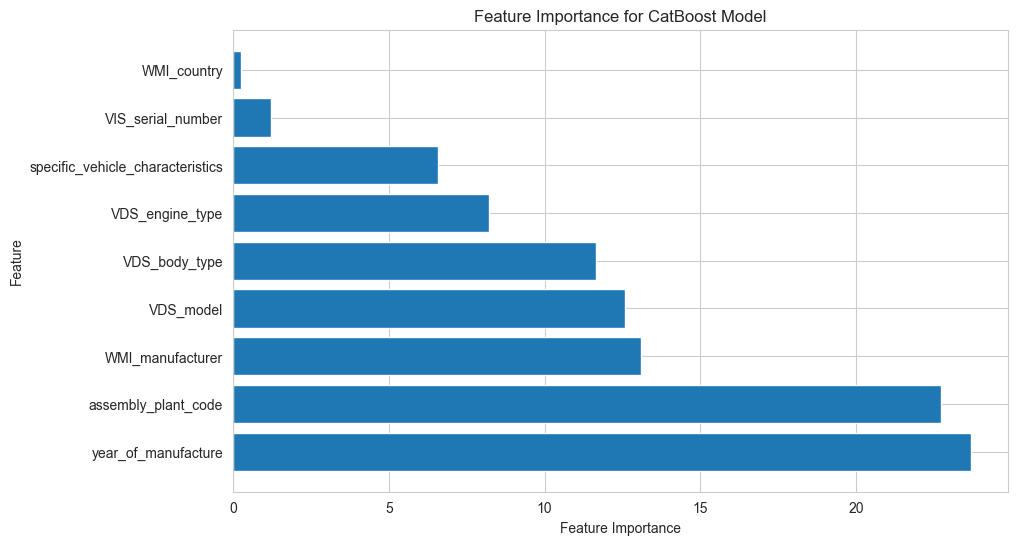

In [25]:
# Cоздадим горизонтальную столбчатую диаграмму, 
# отображающую важность каждого признака в модели CatBoost. 
# Важность признаков сортируется по убыванию

# Получаем важность признаков
feature_importance = model.feature_importances_

# Получаем названия признаков
feature_names = X_train.columns

# Сортируем важность признаков и их названия по убыванию
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Создаем график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.yticks(range(len(sorted_feature_importance)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for CatBoost Model')
plt.show()

Общий вывод.  
Использовали регулярные выражения в питоне, способы их обработки и т.д.  
Провели исследование зависимости цены на подержанные автомобили от ВИН-кода.  
Определили значимость признаков.  
Получили метрики качества:   
0	MAPE	19.81  
1	RMSE	2790.63  
2	MSE 	7787619.35  
3	MAE  	1940.67  
4	R2	    0.87    
Использовали модель CatBoost с дефолтными параметрами.  
ВИН-код, хотя и является важным параметром, его абсолютно недостаточно для оценки стоимости автомобиля.  
Полученное исследование можно масштабировать на любые наборы данных, добавляя модули проверки ВИН-кода, а также добавляя признаки и их обработку.  
Улучшать метрики качества модели считаю нецелесообразным, т.к. это приведет к переобучению модели и недостоверным данным в эксплуатации.  
Добавили проверку модели на данных.  